<a href="https://colab.research.google.com/github/UrukHan/NeuroNetStockQuotes/blob/master/DownloadApiData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Импорт библиотек**

In [1]:
!pip install alpha_vantage

     |████████████████████████████████| 1.2MB 3.7MB/s 
     |████████████████████████████████| 153kB 18.3MB/s 
     |████████████████████████████████| 266kB 15.2MB/s 
  Created wheel for alpha-vantage: filename=alpha_vantage-2.2.0-cp36-none-any.whl size=25706 sha256=401479b18fceb71de24e2da4e02299647f9bb558f8e31f2721654efecb8e2e35
  Stored in directory: /root/.cache/pip/wheels/3a/fa/05/80b0afcbd2a4de8bd2a0c5cd77084e3d3a9cc12c48be9b7f84
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=bfe35f8658782f5cdc99ccddfa1d42d0f406dc95022228b0439dbb4ab8d9f637
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built alpha-vantage idna-ssl


In [2]:
import requests
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Clear logs from previous calls
!rm -rf ./logs/ 

# Check
!ls

sample_data


### **Скачивание данных через API с https://www.alphavantage.co/**

In [4]:
# Ввод ключа (IQLCQLXYBPW3LH7T)
key = 'IQLCQLXYBPW3LH7T' #input('Введите ключ доступа   -   ') 

In [5]:
# Считывание в массив наименований компаний с .txt
"""symbolCode = []
with open('CompaniesList.txt') as f:
    listTitleCompany = f.read()
    symbolCode = listTitleCompany.split(" ")"""
symbolCode = ['BA', 'AXP', 'CAT', 'GS', 'HD', 'F', 'DAL', 'BAC', 'WFC', 'CPE']    
print(symbolCode)

['BA', 'AXP', 'CAT', 'GS', 'HD', 'F', 'DAL', 'BAC', 'WFC', 'CPE']


In [6]:
# Скачивание и запись в Dictionary Базы Данных
countCompany = len(symbolCode)
stockQuotes = {}
lengthDateBase = []
# Задаем задержку т.к. сайт отдает данные по 5ти фирмам в минуту
sleepFor = 0 
ts = TimeSeries(key=key)
for i in range (countCompany):
    sleepFor += 1
    if sleepFor % 5 == 0:
        time.sleep(61)
    # Запрос данных API
    data, meta_data = ts.get_intraday(symbol=symbolCode[i],interval='60min', outputsize='full')

    # Запись нужных параметров в массив
    times = []
    prices = []
    for key, price in data.items():
#        timeD = datetime.strptime(key, "%Y-%m-%d %H:%M:%S")
        timeD = key
        times.append(timeD)
        prices.append(price['1. open'])
    lengthDateBase.append(len(times))
    timesPrices = [times, prices]
    # Создание словаря
    stockQuotes[symbolCode[i]] = timesPrices
#    print(stockQuotes)
# print(stockQuotes)
print(symbolCode)
print(max(lengthDateBase))
print(len(symbolCode))


['BA', 'AXP', 'CAT', 'GS', 'HD', 'F', 'DAL', 'BAC', 'WFC', 'CPE']
655
10


### **Преоброзование данных в удобную для анализа форму**

In [7]:
# Создание копии Данных
stockQuotesReserve = stockQuotes.copy() 

In [8]:
pdStockQuotes = []
for key, timePrice in stockQuotes.items():
    times = timePrice[0]
    prices = timePrice[1]
    for i in range (len(times)):
        
        pdStockQuotes.append([key, times[i], prices[i]])

In [9]:
# Запись промежуточных данных в файл
with open('TimeSeries.json', 'w') as f:
    f.write(json.dumps(pdStockQuotes))

In [10]:
AllDataBase = pd.read_json('/content/TimeSeries.json')
AllDataBase.columns = ['Company', 'DataTime', 'Price']
#AllDataBase = AllDataBase.sort_values(by=['DateTime'], ascending=False)
AllDataBase

,Company,DataTime,Price
0,BA,2020-08-31 20:00:00,172.0700
1,BA,2020-08-31 19:00:00,171.9300
2,BA,2020-08-31 18:00:00,172.0900
3,BA,2020-08-31 17:00:00,171.8200
4,BA,2020-08-31 16:00:00,172.4400
...,...,...,...
5929,CPE,2020-07-07 09:00:00,1.1601
5930,CPE,2020-07-07 08:00:00,1.1800
5931,CPE,2020-07-07 07:00:00,1.1700
5932,CPE,2020-07-07 06:00:00,1.1500


In [11]:
allData = (AllDataBase
       .pivot(index="DataTime", columns="Company", values="Price")
       .rename_axis(None, axis=1)
       .reset_index())
allData

,DataTime,AXP,BA,BAC,CAT,CPE,DAL,F,GS,HD,WFC
0,2020-07-06 05:00:00,95.500,185.15,23.78,NaN,NaN,28.3500,6.07,NaN,NaN,26.00
1,2020-07-06 06:00:00,NaN,184.70,23.90,NaN,NaN,28.5000,6.11,NaN,NaN,26.05
2,2020-07-06 07:00:00,97.000,185.15,23.95,NaN,NaN,28.6500,6.12,202.370,NaN,26.10
3,2020-07-06 08:00:00,96.140,185.67,23.92,129.6500,NaN,28.5100,6.15,202.710,252.0000,26.10
4,2020-07-06 09:00:00,96.000,184.10,23.80,130.9109,NaN,28.4767,6.14,202.735,252.2398,25.89
...,...,...,...,...,...,...,...,...,...,...,...
651,2020-08-31 16:00:00,101.695,172.44,25.73,142.6050,6.5499,30.9650,6.83,204.860,285.6200,24.21
652,2020-08-31 17:00:00,101.590,171.82,25.74,142.3100,6.5600,30.8500,6.83,204.870,285.0400,24.15
653,2020-08-31 18:00:00,101.640,172.09,25.75,142.7500,6.6400,30.9200,6.82,NaN,284.6100,24.15
654,2020-08-31 19:00:00,NaN,171.93,25.72,142.2500,NaN,30.9500,6.82,NaN,284.9999,24.17


## **Обработка и анализ данных**

In [12]:
# Проверка на отсутствующие значения
allData_na = allData.isnull().sum()
allData_na = allData_na.drop(allData_na[allData_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :allData_na})
missing_data.iloc[0:10]

,Missing Ratio
CAT,148
AXP,132
HD,123
GS,111
CPE,61
F,38
WFC,9
DAL,2
BAC,1
BA,1


In [13]:
noneDataLabel = missing_data.index.values
#noneDataCount = missing_data.reset_index(level = 0)['Missing Ratio'].values
noneDataLabel

array(['CAT', 'AXP', 'HD', 'GS', 'CPE', 'F', 'WFC', 'DAL', 'BAC', 'BA'],
      dtype=object)

In [14]:
# Заполнение отсутствующих значений
allData = allData.fillna(method='ffill')
allData = allData.fillna(method='bfill')
allData.iloc[0:5]

,DataTime,AXP,BA,BAC,CAT,CPE,DAL,F,GS,HD,WFC
0,2020-07-06 05:00:00,95.50,185.15,23.78,129.6500,1.18,28.3500,6.07,202.370,252.0000,26.00
1,2020-07-06 06:00:00,95.50,184.70,23.90,129.6500,1.18,28.5000,6.11,202.370,252.0000,26.05
2,2020-07-06 07:00:00,97.00,185.15,23.95,129.6500,1.18,28.6500,6.12,202.370,252.0000,26.10
3,2020-07-06 08:00:00,96.14,185.67,23.92,129.6500,1.18,28.5100,6.15,202.710,252.0000,26.10
4,2020-07-06 09:00:00,96.00,184.10,23.80,130.9109,1.18,28.4767,6.14,202.735,252.2398,25.89


In [15]:
allData = allData.drop(['DataTime'], axis=1)
allData

,AXP,BA,BAC,CAT,CPE,DAL,F,GS,HD,WFC
0,95.500,185.15,23.78,129.6500,1.1800,28.3500,6.07,202.370,252.0000,26.00
1,95.500,184.70,23.90,129.6500,1.1800,28.5000,6.11,202.370,252.0000,26.05
2,97.000,185.15,23.95,129.6500,1.1800,28.6500,6.12,202.370,252.0000,26.10
3,96.140,185.67,23.92,129.6500,1.1800,28.5100,6.15,202.710,252.0000,26.10
4,96.000,184.10,23.80,130.9109,1.1800,28.4767,6.14,202.735,252.2398,25.89
...,...,...,...,...,...,...,...,...,...,...
651,101.695,172.44,25.73,142.6050,6.5499,30.9650,6.83,204.860,285.6200,24.21
652,101.590,171.82,25.74,142.3100,6.5600,30.8500,6.83,204.870,285.0400,24.15
653,101.640,172.09,25.75,142.7500,6.6400,30.9200,6.82,204.870,284.6100,24.15
654,101.640,171.93,25.72,142.2500,6.6400,30.9500,6.82,204.870,284.9999,24.17


In [16]:
# Проверка на отсутствующие значения
allData_na = allData.isnull().sum()
allData_na = allData_na.drop(allData_na[allData_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :allData_na})
missing_data.iloc[0:10]

,Missing Ratio


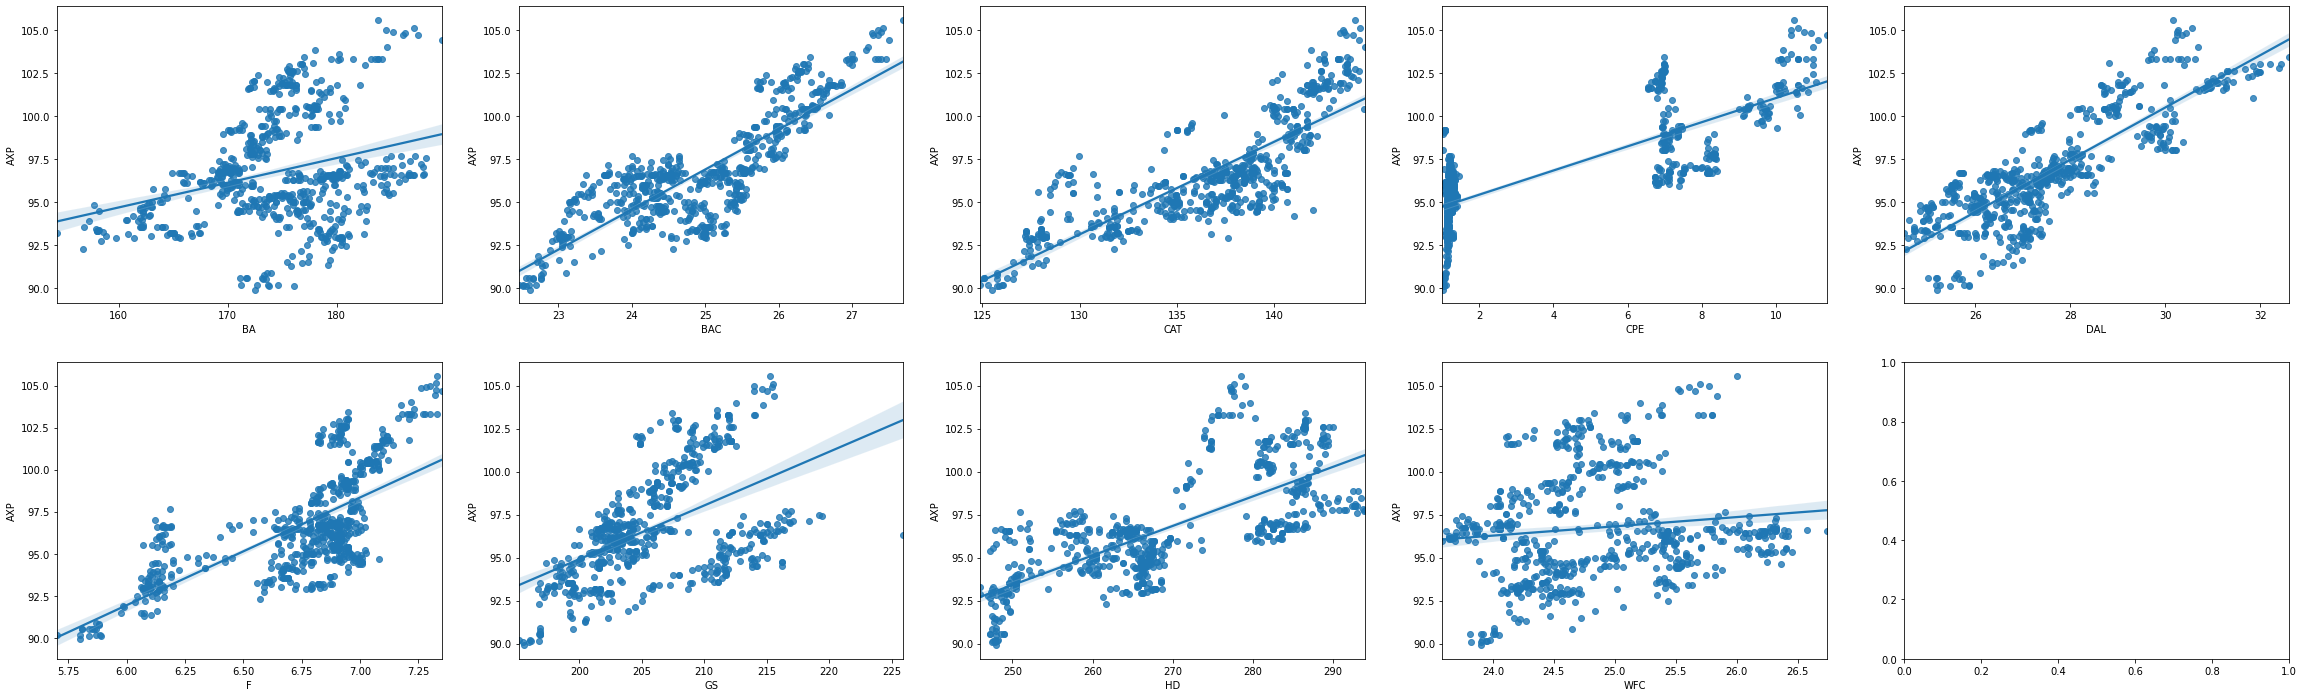

In [17]:
# Анализ коореляции всех перемнных с целью
qualitative = allData.columns.tolist()
del qualitative[0]
fig, ax = plt.subplots(round(len(qualitative)/5), 5, figsize = (40, 12))
for var, subplot in zip(qualitative, ax.flatten()):
    sns.set(font_scale = 1.5) 
    sns.regplot(x = var, y = 'AXP', data = allData, ax = subplot);

In [18]:
# Удаление лишних данных
allData = allData.drop(['CPE'], axis=1)
allData

,AXP,BA,BAC,CAT,DAL,F,GS,HD,WFC
0,95.500,185.15,23.78,129.6500,28.3500,6.07,202.370,252.0000,26.00
1,95.500,184.70,23.90,129.6500,28.5000,6.11,202.370,252.0000,26.05
2,97.000,185.15,23.95,129.6500,28.6500,6.12,202.370,252.0000,26.10
3,96.140,185.67,23.92,129.6500,28.5100,6.15,202.710,252.0000,26.10
4,96.000,184.10,23.80,130.9109,28.4767,6.14,202.735,252.2398,25.89
...,...,...,...,...,...,...,...,...,...
651,101.695,172.44,25.73,142.6050,30.9650,6.83,204.860,285.6200,24.21
652,101.590,171.82,25.74,142.3100,30.8500,6.83,204.870,285.0400,24.15
653,101.640,172.09,25.75,142.7500,30.9200,6.82,204.870,284.6100,24.15
654,101.640,171.93,25.72,142.2500,30.9500,6.82,204.870,284.9999,24.17


In [19]:
qualitative.remove('CPE')
qualitative

['BA', 'BAC', 'CAT', 'DAL', 'F', 'GS', 'HD', 'WFC']

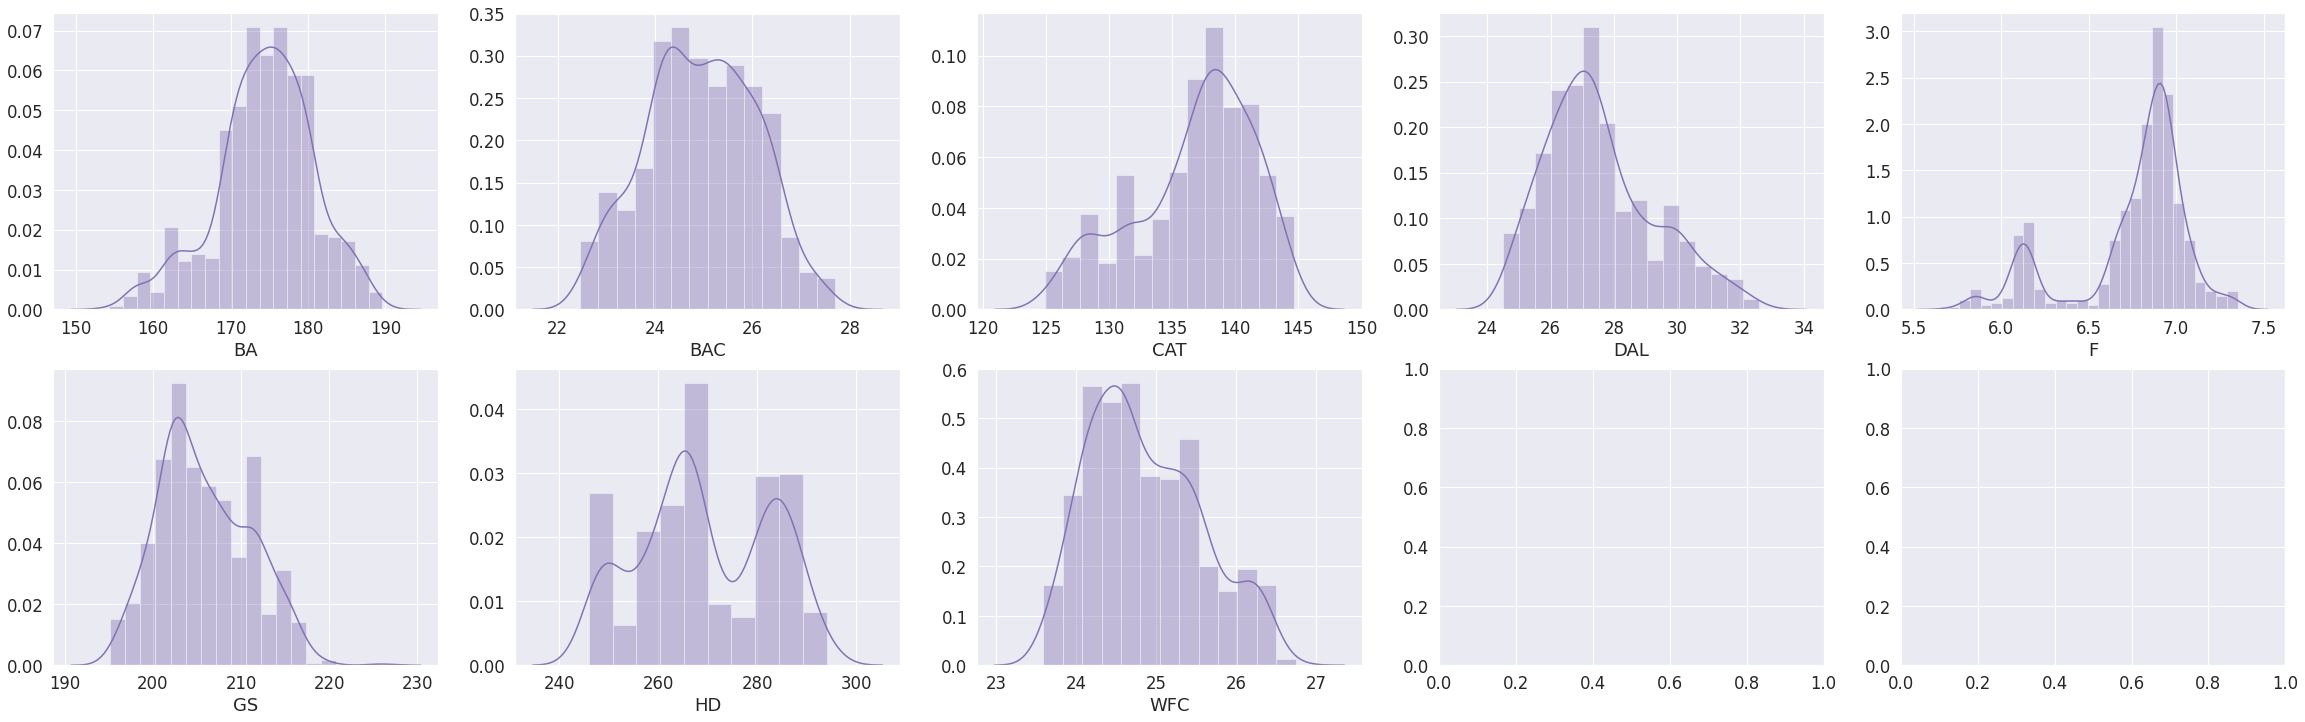

In [20]:
# Построение логнормального и нормального распределений. нормализация данных

# Вывод гистограмм
fig, ax = plt.subplots(round(len(qualitative)/5), 5, figsize = (40, 12))
for var, subplot in zip(qualitative, ax.flatten()):
    sns.set(font_scale = 1.5) 
    try:
        sns.distplot(allData[var], color="m", ax = subplot)
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
            sns.distplot(allData, kde_kws={'bw': 0.1})
        else:
            raise re

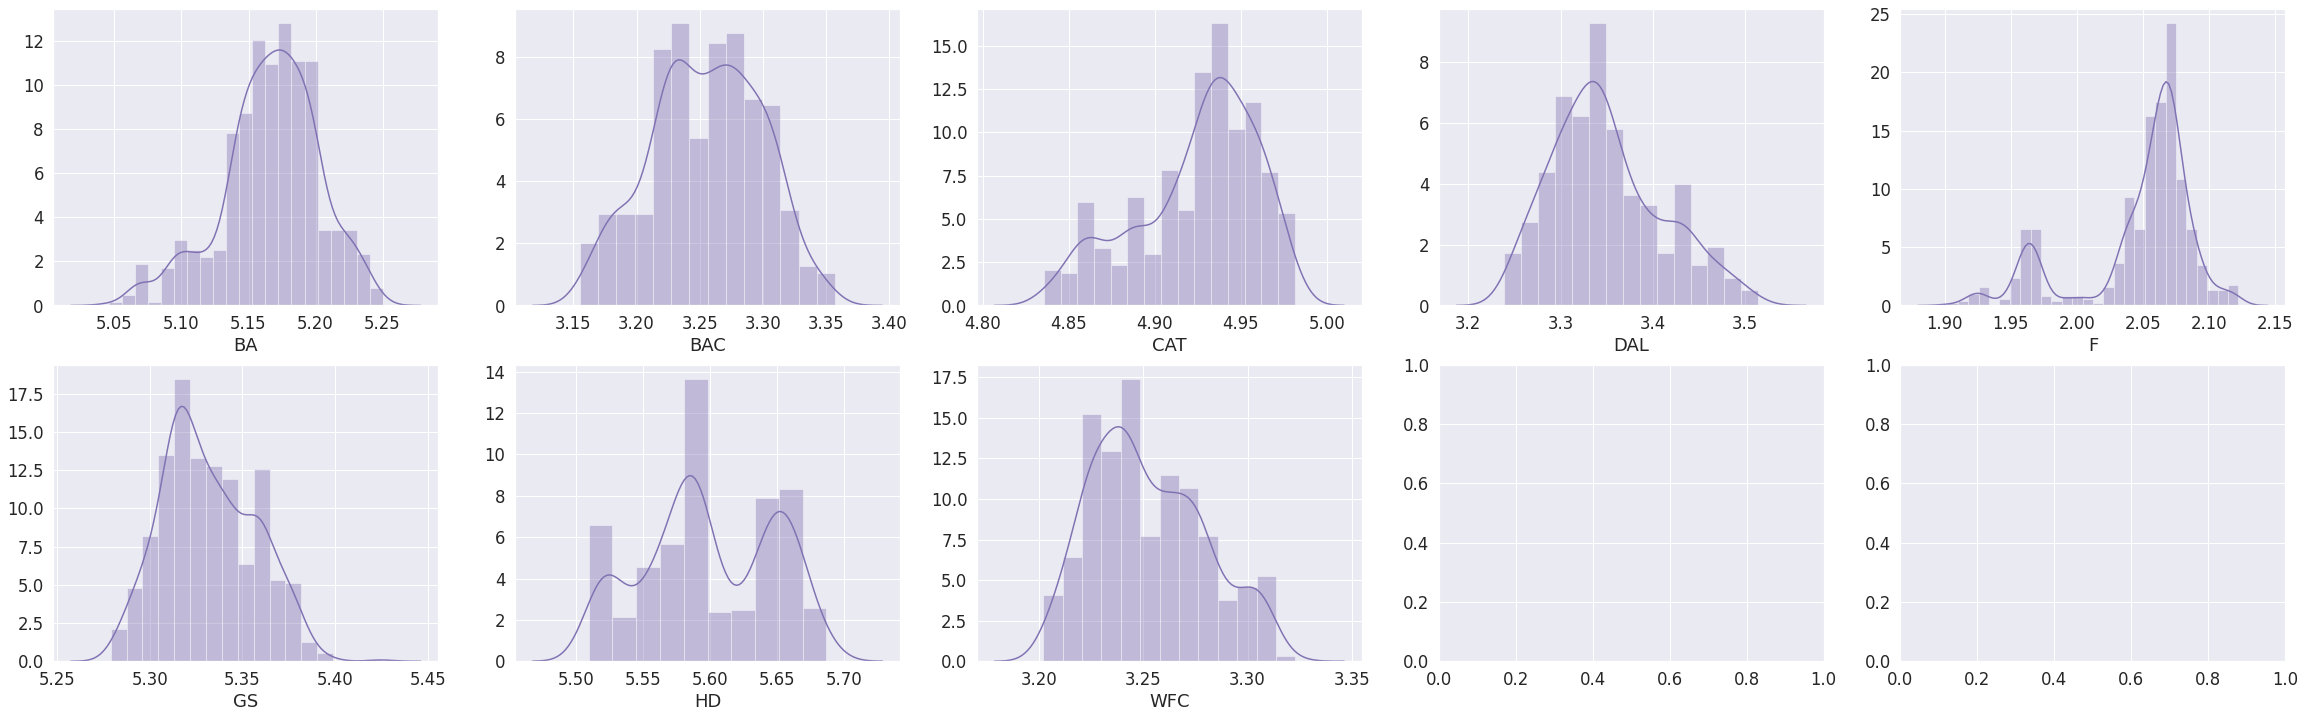

In [21]:
# Нормализация данных
for param in qualitative:
    print()
    (mu, sigma) = norm.fit(allData[param])
    allData[param] = np.log1p(allData[param])
# Вывод гистограмм
fig, ax = plt.subplots(round(len(qualitative)/5), 5, figsize = (40, 12))
for var, subplot in zip(qualitative, ax.flatten()):
    sns.set(font_scale = 1.5) 
    sns.distplot(allData[var], color="m", ax = subplot)

In [25]:
# Среднее значение
mean = allData.mean(axis=0)
# Стандартное отклонение
std = allData.std(axis=0)
# Нормализация данных
allData -= mean
allData /= std
allData

,AXP,BA,BAC,CAT,DAL,F,GS,HD,WFC
0,-0.400941,1.654158,-1.039897,-1.503349,0.501252,-2.077808,-0.679406,-1.355350,1.606728
1,-0.400941,1.587469,-0.928147,-1.503349,0.586912,-1.948963,-0.679406,-1.355350,1.675267
2,0.079124,1.654158,-0.881743,-1.503349,0.672136,-1.916865,-0.679406,-1.355350,1.743679
3,-0.196114,1.731021,-0.909574,-1.503349,0.592607,-1.820841,-0.611869,-1.355350,1.743679
4,-0.240920,1.498298,-1.021235,-1.227408,0.573634,-1.852804,-0.606907,-1.335722,1.455495
...,...,...,...,...,...,...,...,...,...
651,1.581728,-0.294471,0.712362,1.212890,1.935410,0.253968,-0.187387,1.229592,-0.934429
652,1.548123,-0.393144,0.721014,1.153812,1.874848,0.253968,-0.185423,1.187625,-1.022702
653,1.564126,-0.350130,0.729663,1.241884,1.911738,0.224782,-0.185423,1.156456,-1.022702
654,1.564126,-0.375612,0.703706,1.141781,1.927523,0.224782,-0.185423,1.184720,-0.993255


In [26]:
allData.to_json('stockQuotes.json')